In [1]:
import numpy as np
import pandas as pd
from numpy import dtype
from datetime import datetime as dt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
dtype={'tiprel_1mes': np.str, 'ult_fec_cli_1t':np.str, 'indrel_1mes':np.str}

parse_dates = ['fecha_alta', 'ult_fec_cli_1t']

iter_csv = pd.read_csv('../data/processed/train-processed.csv.gz', skipinitialspace = True, 
                       iterator=True, chunksize=50000, dtype=dtype, parse_dates=parse_dates)

#data = pd.concat([chunk[chunk['ncodpers'].between(660248, 660250)] for chunk in iter_csv]) #Small dataset could be used for testing
data = pd.concat([chunk for chunk in iter_csv], ignore_index=True)

C:\dev\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2825: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
# "removed corrupted data and redundant"
data = data[data.sexo.notnull()]
data.drop('conyuemp', axis=1, inplace=True) # Contains just single diff value. All others same
data.drop('tipodom', axis=1, inplace=True)

# "converting dates to timestamps"
data.fecha_alta = data.fecha_alta.astype('int64')//1e9
data.ult_fec_cli_1t = data.ult_fec_cli_1t.astype('int64')//1e9

# "ind_empleado"
ind_empleado = pd.get_dummies(data.ind_empleado, prefix = 'ind_empleado')
data.drop('ind_empleado', axis=1, inplace=True)
data = pd.concat([data, ind_empleado], axis=1)

# "tiprel_1mes"
tiprel_1mes = pd.get_dummies(data.tiprel_1mes, prefix = 'tiprel_1mes')
data.drop('tiprel_1mes', axis=1, inplace=True)
data = pd.concat([data, tiprel_1mes], axis=1)

data.canal_entrada = data.canal_entrada.replace([None], ['nan'])
data.renta = data.renta.replace([float('nan')], [0.])
data.cod_prov = data.cod_prov.replace([float('nan')], [0.])
data.indrel = data.indrel.replace([99.], [0.])
data.indrel_1mes = data.indrel_1mes.replace(['P', float('nan')], [5., 6.])
data.indrel_1mes = pd.to_numeric(data.indrel_1mes)

data.indfall = data.indfall.replace(['S','N'], [1.,0.])
data.reset_index(drop=True, inplace=True)

### coordinates feature
Load external dictionary of coordinates and replace code with coordinates in dataset

In [4]:
countries = pd.read_csv('../data/external/countries.csv', header=None)
countries.columns=['pais_residencia', 'lat', 'lon']

train_countries_df = pd.DataFrame(data=data[['ncodpers','pais_residencia']])
coordinates_feature = pd.merge(train_countries_df, countries, on = 'pais_residencia')

data = pd.merge(data, coordinates_feature, on = 'ncodpers', suffixes=('_x', '_y'))
data.drop(['pais_residencia_x', 'pais_residencia_y'], axis=1, inplace=True)
data.tail()

,ncodpers,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,ind_empleado_A,ind_empleado_B,ind_empleado_F,ind_empleado_N,ind_empleado_S,tiprel_1mes_A,tiprel_1mes_I,tiprel_1mes_P,tiprel_1mes_R,lat,lon
949604,1166765,1.0,22.0,1376438400,0.0,33.0,1.0,-9223372037,1.0,1.0,0.0,KHE,0.0,50.0,0.0,43912.17,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,0,1,0,0,40.0,-4.0
949605,1166764,1.0,23.0,1376438400,0.0,33.0,1.0,-9223372037,1.0,1.0,0.0,KHE,0.0,26.0,0.0,23334.99,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0,0,0,1,0,0,1,0,0,40.0,-4.0
949606,1166763,0.0,47.0,1376438400,0.0,33.0,1.0,-9223372037,1.0,1.0,0.0,KHE,0.0,50.0,1.0,0.00,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,1,0,0,0,40.0,-4.0
949607,1166789,0.0,22.0,1376438400,0.0,33.0,1.0,-9223372037,1.0,1.0,0.0,KHE,0.0,50.0,0.0,199592.82,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,0,1,0,0,40.0,-4.0
949608,1550586,0.0,37.0,1463097600,1.0,0.0,1.0,-9223372037,6.0,1.0,0.0,nan,0.0,28.0,1.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,0,0,0,0,40.0,-4.0


In [5]:
for col, col_data in data.iteritems():
    if col != 'antiguedad' and not col.endswith('_ult1'):
        print (col, col_data.unique())
        print ("###")

ncodpers [ 641620  641917  642089 ..., 1166763 1166789 1550586]
###
sexo [ 0.  1.]
###
age [  70.   45.   73.   34.   47.  103.   41.   11.   66.   44.   31.   37.
   33.   78.   85.   30.   14.   19.   39.   71.   38.   35.   52.   32.
   83.   56.   36.   87.   61.   49.   20.   90.   59.   12.   40.   57.
   43.   51.   68.   46.   84.   22.   15.   92.   58.   50.   48.   42.
   54.   17.   67.   53.   65.   25.   23.   24.   29.   26.   28.   27.
    9.   55.   69.   63.   93.   80.   72.   60.   74.   89.   82.   77.
  102.   91.   81.   76.   95.   16.   97.   64.   75.    7.   21.  101.
   62.   88.   86.   96.   98.   18.    4.    8.   79.  100.   94.   13.
   10.   99.    2.    6.  104.    5.  116.  112.  110.  105.  108.  106.
  111.  109.  114.  107.  113.  127.  117.  164.  115.    3.]
###
fecha_alta [1277769600 1161734400 1158451200 ..., 1419465600 1377388800 1418428800]
###
ind_nuevo [ 0.  1.]
###
indrel [ 0.  1.]
###
ult_fec_cli_1t [ 1435708800  1438214400  1436400000  

In [11]:
clean_data = data.drop('canal_entrada', axis=1)

In [7]:
from sklearn import preprocessing
clean_data_without_id = clean_data.drop('ncodpers', axis=1)
x = clean_data_without_id.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [8]:
df.columns=list(clean_data_without_id.columns.values)
df.tail()

,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,indresi,indext,indfall,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,ind_empleado_A,ind_empleado_B,ind_empleado_F,ind_empleado_N,ind_empleado_S,tiprel_1mes_A,tiprel_1mes_I,tiprel_1mes_P,tiprel_1mes_R,lat,lon
949604,1.0,0.123457,0.869203,0.0,0.999777,1.0,0.0,0.0,1.0,0.0,0.0,0.961538,0.0,0.001520,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.764151,0.355072
949605,1.0,0.129630,0.869203,0.0,0.999777,1.0,0.0,0.0,1.0,0.0,0.0,0.500000,0.0,0.000808,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.764151,0.355072
949606,0.0,0.277778,0.869203,0.0,0.999777,1.0,0.0,0.0,1.0,0.0,0.0,0.961538,1.0,0.000000,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.764151,0.355072
949607,0.0,0.123457,0.869203,0.0,0.999777,1.0,0.0,0.0,1.0,0.0,0.0,0.961538,0.0,0.006908,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.764151,0.355072
949608,0.0,0.216049,0.997694,1.0,0.999744,1.0,0.0,1.0,1.0,0.0,0.0,0.538462,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.764151,0.355072


In [9]:
normalized_data = pd.concat([clean_data['ncodpers'], df], axis=1)
normalized_data.to_csv('../data/processed/train-normalized.csv.gz', index=False, compression='gzip')

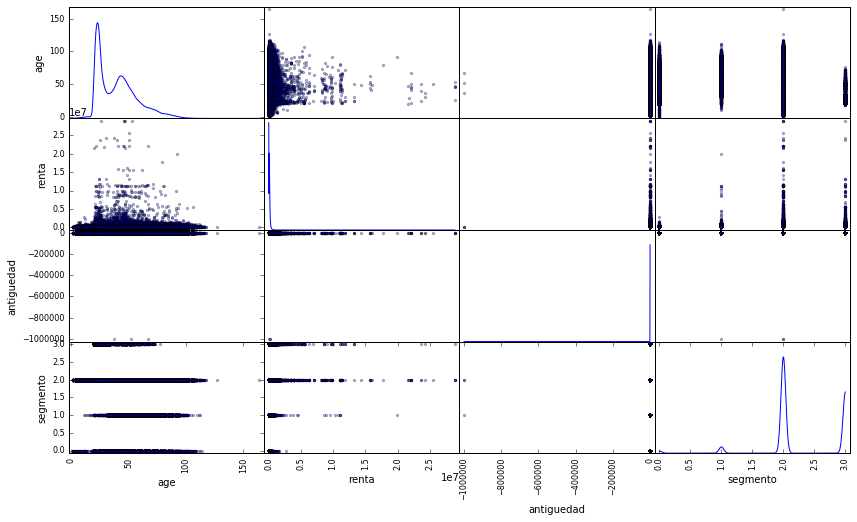

In [10]:
#Just looking on correlation of some features which potentually might correlate.
pd.scatter_matrix(clean_data.ix[:,['age','renta','antiguedad','segmento']], alpha = 0.3, figsize = (14,8), diagonal = 'kde');